In [278]:
# pkgs used
import pandas as pd
import numpy as np
import sqlite3
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, ttest_ind
from imblearn.over_sampling import SMOTE
import random
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,cross_val_score
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [93]:
# this csv file is not utf-8 encoded
users = pd.read_csv("takehome_users-intern.csv",encoding = "ISO-8859-1")

In [8]:
eng = pd.read_csv("takehome_user_engagement-intern.csv")

## Get adopted users

In [21]:
# Get date from time string
eng['date_stamp'] = [x.split(' ')[0] for x in eng['time_stamp']]

In [26]:
eng.groupby(['user_id', 'date_stamp']).size().unique()

array([1])

each ('user_id', 'date_stamp') pair is unique

In [69]:
eng = eng.drop(['time_stamp', 'visited'], axis = 1)

In [28]:
conn = sqlite3.connect('asana.db')

In [73]:
eng.to_sql("eng", conn, if_exists="replace", index = False)

In [81]:
users.to_sql("users", conn, if_exists="replace", index = False)

In [85]:
adpt_users = pd.read_sql('select u.object_id user_id, (case when sub2.user_id is null then 0 else 1 end) \
as adopted from users u left outer join (select distinct user_id  \
from (select e1.user_id, e1.date_stamp d1  \
from eng e1 join eng e2 on e1.user_id = e2.user_id and e1.date_stamp < e2.date_stamp \
where Julianday(e2.date_stamp) - Julianday(e1.date_stamp) < 7  \
group by 1, 2 having count(e2.date_stamp) >= 2) sub1)sub2 on u.object_id = sub2.user_id', conn)

In [87]:
#adpt_users.to_csv("adpt_users.csv", index=False)

## Data Cleaning and Feature Engineering

Let's take a look at users table and check each column:

object_id: to join with adpt_users

creation_time: weekend/weekday, which day of week, time in a day

name:

email:

creation_source: might be an important categorical feature

last_session_creation_time: 

opted_in_to_mailing_list: might be an important categorical feature

enabled_for_marketing_drip: might be an important categorical feature

org_id: big/small org

invited_by_user_id: if invited, if the user invited this person is adopted by the time this invited person registered (might be too complicate for 3 hours)

email_domain: business or personal



In [94]:
temp = users['creation_time'].apply(lambda x: pd.to_datetime(x).weekday())
users['weekday'] = temp.apply(lambda x: 1 if x < 5 else 0)
users['day_of_week'] = temp

In [108]:
users['hour'] = users['creation_time'].apply(lambda x: pd.to_datetime(x).hour)

In [112]:
creation_source_dummies = pd.get_dummies(users['creation_source'], prefix='creation_source')

In [113]:
data = users.join(creation_source_dummies)

In [128]:
org = pd.DataFrame(users.groupby('org_id').size())
org = org.reset_index()
org.columns = ['org_id', 'org_size']

In [132]:
data = data.merge(org, how = 'left')

In [135]:
data = data.merge(adpt_users, left_on = 'invited_by_user_id', right_on = 'user_id', how = 'left')

In [138]:
data = data.drop(['user_id'], axis = 1)

In [151]:
new_c = list(data.columns)
new_c = ['invite_adopted' if x=='adopted' else x for x in new_c]

In [153]:
data.columns = new_c

In [164]:
data.email_domain.unique()

array(['yahoo.com', 'gustr.com', 'jourrapide.com', ..., 'uyhoy.com',
       'eaouk.com', 'iuxiw.com'], dtype=object)

In [166]:
data['common_email'] = [1 if x in ['gmail.com', 'hotmail.com', 'yahoo.com'] else 0 for x in data['email_domain']]

In [167]:
data.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,...,day_of_week,hour,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,org_size,invite_adopted,common_email
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803,...,1,3,1,0,0,0,0,75,0.0,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316,...,4,3,0,1,0,0,0,233,0.0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525,...,1,23,0,1,0,0,0,32,1.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151,...,1,8,1,0,0,0,0,233,1.0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240,...,3,10,1,0,0,0,0,16,1.0,1


Choose possible features

In [189]:
df = data[['object_id', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 
       'email_domain', 'weekday', 'day_of_week', 'hour',
       'creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE',
       'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH', 'org_size', 'invite_adopted',
       'common_email']]

In [190]:
df = df.merge(adpt_users, left_on = 'object_id', right_on='user_id',how = 'outer')
df = df.drop(['user_id'], axis = 1)

In [194]:
#df.to_csv("df.csv", index=False)

## Association Exploring

### Imbalanced Data

In [204]:
df.describe()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,weekday,day_of_week,hour,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,org_size,invite_adopted,common_email,adopted
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,6417.000000,12000.000000,12000.000000
mean,6000.50000,0.249500,0.149333,141.884583,0.723500,2.998167,11.564333,0.180250,0.354500,0.175917,0.173917,0.115417,55.108500,0.169705,0.597833,0.133500
std,3464.24595,0.432742,0.356432,124.056723,0.447286,1.981243,6.914888,0.384412,0.478381,0.380765,0.379054,0.319537,64.023959,0.375403,0.490356,0.340128
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
25%,3000.75000,0.000000,0.000000,29.000000,0.000000,1.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000
50%,6000.50000,0.000000,0.000000,108.000000,1.000000,3.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,0.000000,1.000000,0.000000
75%,9000.25000,0.000000,0.000000,238.250000,1.000000,5.000000,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,55.000000,0.000000,1.000000,0.000000
max,12000.00000,1.000000,1.000000,416.000000,1.000000,6.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,319.000000,1.000000,1.000000,1.000000


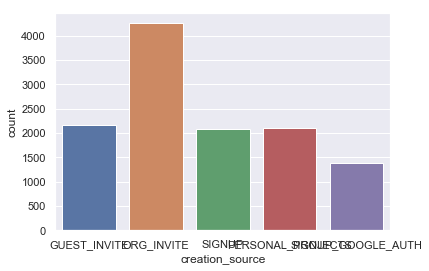

In [175]:
sns.set(style="darkgrid")
sns.countplot(x="creation_source", data=data)

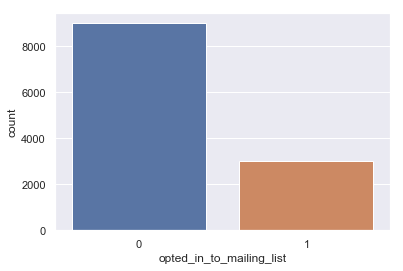

In [176]:
sns.countplot(x="opted_in_to_mailing_list", data=data)

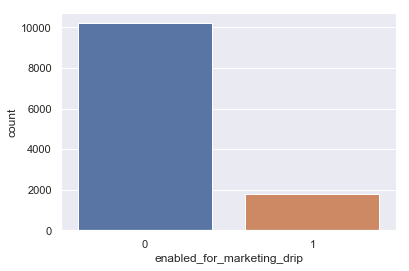

In [177]:
sns.countplot(x="enabled_for_marketing_drip", data=data)

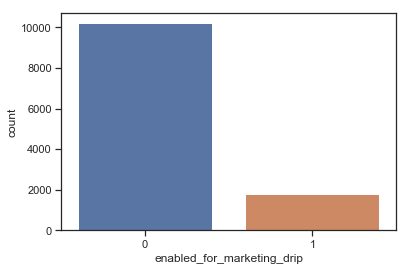

In [179]:
sns.countplot(x="enabled_for_marketing_drip", data=data)

In [191]:
df.columns

Index(['object_id', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip',
       'org_id', 'email_domain', 'weekday', 'day_of_week', 'hour',
       'creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE',
       'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH', 'org_size', 'invite_adopted',
       'common_email', 'adopted'],
      dtype='object')

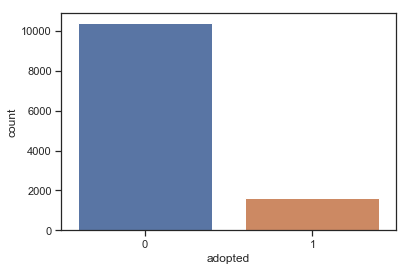

In [193]:
sns.countplot(x="adopted", data=df)

### Data Visualization

Tableau

https://public.tableau.com/views/asana/Dashboard1?:embed=y&:display_count=yes&publish=yes&:origin=viz_share_link

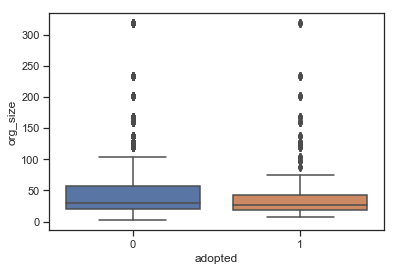

In [201]:
sns.boxplot(x="adopted", y="org_size", data=df)

### Statistical Tests

categorical - categorical: chi-square test

categorical - numerical: t-test, anova test

chi-squared table: https://www.medcalc.org/manual/chi-square-table.php

In [208]:
chi2_contingency(pd.crosstab(df.adopted, df.weekday))

(0.40058357872821504, 0.5267880263545985, 1, array([[2875.047, 7522.953],
        [ 442.953, 1159.047]]))

In [209]:
chi2_contingency(pd.crosstab(df.adopted, df.opted_in_to_mailing_list))

(0.7327718655131716, 0.3919861918708256, 1, array([[7803.699, 2594.301],
        [1202.301,  399.699]]))

In [210]:
chi2_contingency(pd.crosstab(df.adopted, df.enabled_for_marketing_drip))

(0.22279770974709384, 0.6369164225605993, 1, array([[8845.232, 1552.768],
        [1362.768,  239.232]]))

In [211]:
chi2_contingency(pd.crosstab(df.adopted, df.day_of_week))

(2.4000917477749204,
 0.8794771504279582,
 6,
 array([[1483.448 , 1434.924 , 1463.5185, 1562.2995, 1578.763 , 1439.2565,
         1435.7905],
        [ 228.552 ,  221.076 ,  225.4815,  240.7005,  243.237 ,  221.7435,
          221.2095]]))

In [212]:
chi2_contingency(pd.crosstab(df.adopted, df.hour))

(32.84744859269706,
 0.08376189397940113,
 23,
 array([[415.0535, 424.585 , 436.716 , 421.9855, 431.517 , 452.313 ,
         394.2575, 428.9175, 435.8495, 451.4465, 429.784 , 458.3785,
         452.313 , 448.847 , 422.852 , 394.2575, 408.1215, 436.716 ,
         431.517 , 464.444 , 441.915 , 449.7135, 417.653 , 448.847 ],
        [ 63.9465,  65.415 ,  67.284 ,  65.0145,  66.483 ,  69.687 ,
          60.7425,  66.0825,  67.1505,  69.5535,  66.216 ,  70.6215,
          69.687 ,  69.153 ,  65.148 ,  60.7425,  62.8785,  67.284 ,
          66.483 ,  71.556 ,  68.085 ,  69.2865,  64.347 ,  69.153 ]]))

In [213]:
chi2_contingency(pd.crosstab(df.adopted, df.creation_source_GUEST_INVITE))

(24.39698696183801, 7.839120263575109e-07, 1, array([[8523.7605, 1874.2395],
        [1313.2395,  288.7605]]))

In [214]:
chi2_contingency(pd.crosstab(df.adopted, df.creation_source_ORG_INVITE))

(0.6536181716669327, 0.41882205136947515, 1, array([[6711.909, 3686.091],
        [1034.091,  567.909]]))

In [215]:
chi2_contingency(pd.crosstab(df.adopted, df.creation_source_PERSONAL_PROJECTS))

(68.39491375711462, 1.3382228495700213e-16, 1, array([[8568.8185, 1829.1815],
        [1320.1815,  281.8185]]))

In [216]:
chi2_contingency(pd.crosstab(df.adopted, df.creation_source_SIGNUP))

(0.966778321848715, 0.32548497250464636, 1, array([[8589.6145, 1808.3855],
        [1323.3855,  278.6145]]))

In [217]:
chi2_contingency(pd.crosstab(df.adopted, df.creation_source_SIGNUP_GOOGLE_AUTH))

(15.324279752345221, 9.054525886904489e-05, 1, array([[9197.8975, 1200.1025],
        [1417.1025,  184.8975]]))

In [218]:
chi2_contingency(pd.crosstab(df.adopted, df.invite_adopted))

(42.59734951842992,
 6.725045045118307e-11,
 1,
 array([[4569.94109397,  934.05890603],
        [ 758.05890603,  154.94109397]]))

In [219]:
chi2_contingency(pd.crosstab(df.adopted, df.common_email))

(5.481274249118708, 0.019221242363991732, 1, array([[4181.729, 6216.271],
        [ 644.271,  957.729]]))

Equal or unequal sample sizes, unequal variances

Welch t test

In [223]:
ttest_ind(df[df['adopted'] == 0]['org_size'], df[df['adopted'] == 1]['org_size'], 
          equal_var=False)


Ttest_indResult(statistic=12.097200385575944, pvalue=7.01263214890657e-33)

In [224]:
ttest_ind(df[df['adopted'] == 0]['hour'], df[df['adopted'] == 1]['hour'], 
          equal_var=False)

Ttest_indResult(statistic=-0.011480997898623545, pvalue=0.9908407630029148)

## Modeling

In [249]:
df.columns

Index(['object_id', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip',
       'org_id', 'email_domain', 'weekday', 'day_of_week', 'hour',
       'creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE',
       'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH', 'org_size', 'invite_adopted',
       'common_email', 'adopted'],
      dtype='object')

In [250]:
df_m = df[['opted_in_to_mailing_list', 'enabled_for_marketing_drip',
       'weekday', 'day_of_week', 'hour','creation_source_GUEST_INVITE', 
        'creation_source_ORG_INVITE','creation_source_PERSONAL_PROJECTS', 
        'creation_source_SIGNUP','creation_source_SIGNUP_GOOGLE_AUTH', 
        'org_size', 'invite_adopted', 'common_email', 'adopted']]

In [251]:
df_m = df_m.fillna(0)

In [252]:
train_list = random.sample(range(df_m.shape[0]), int(df_m.shape[0]*0.7))
test_list = list(set(range(df_m.shape[0]))-set(train_list))

In [253]:
train = df_m.iloc[train_list,:]
test = df_m.iloc[test_list,:]
train=train.reset_index(drop=True)
test=test.reset_index(drop=True)

In [254]:
train_X = train.iloc[:,:-1]
train_y = train.iloc[:,-1]
test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1]

In [255]:
sample_X, sample_y = SMOTE(random_state=18).fit_sample(train_X,train_y)

In [297]:
sample_X = pd.DataFrame(sample_X)
sample_X.columns = train_X.columns

### Decision Tree

In [259]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(sample_X, sample_y)

In [266]:
pred = clf.predict(test_X)

In [277]:
accuracy_score(test_y, pred)

0.7447222222222222

In [273]:
imp = clf.feature_importances_

In [274]:
for i in range(len(imp)):
    print(train.columns[i], imp[i])

opted_in_to_mailing_list 0.03622435968929896
enabled_for_marketing_drip 0.017584524487131676
weekday 0.016835392919999123
day_of_week 0.07998286409669339
hour 0.13155585893144042
creation_source_GUEST_INVITE 0.02186762681547309
creation_source_ORG_INVITE 0.1672813654686245
creation_source_PERSONAL_PROJECTS 0.13393733189272422
creation_source_SIGNUP 0.010810740446237614
creation_source_SIGNUP_GOOGLE_AUTH 0.05033751388368296
org_size 0.1516456773641252
invite_adopted 0.04414329546169233
common_email 0.1377934485428764


In [276]:
confusion_matrix(test_y, pred)

array([[2607,  525],
       [ 394,   74]])

### XGBoost

In [291]:
ac_list = []
for a in [1e-5, 1e-2, 0.1, 1, 1000]:
    
    mean_ac = 0.0   
    n = 5  # repeat the CV procedure 5 times to get more precise results
    SEED = 42
    clf = xgb.XGBClassifier(reg_alpha=a)
    for f in range(n):
        #print(f)
        # for each iteration, randomly hold out 30% of the data as CV set
        X_train, X_cv, y_train, y_cv = train_test_split(sample_X, sample_y, test_size=.30, random_state=f*SEED)
        # train model and make predictions
        mj = clf.fit(X_train,y_train)
        preds = mj.predict(X_cv)
        ac = accuracy_score(list(y_cv),preds)
        mean_ac += ac
    mean_ac = mean_ac/5
    ac_list.append(mean_ac)

In [292]:
ac_list

[0.893348623853211,
 0.8922018348623852,
 0.8938073394495414,
 0.8941743119266056,
 0.4971559633027523]

In [298]:
clf = xgb.XGBClassifier(reg_alpha=1)
mj = clf.fit(sample_X,sample_y)
pred = mj.predict(test_X)

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [299]:
accuracy_score(test_y, pred)

0.8683333333333333

In [300]:
confusion_matrix(test_y, pred)

array([[3125,    7],
       [ 467,    1]])

In [302]:
imp = mj.feature_importances_

In [303]:
for i in range(len(imp)):
    print(train.columns[i], imp[i])

opted_in_to_mailing_list 0.088435374
enabled_for_marketing_drip 0.039115645
weekday 0.06292517
day_of_week 0.12585033
hour 0.12585033
creation_source_GUEST_INVITE 0.037414964
creation_source_ORG_INVITE 0.05612245
creation_source_PERSONAL_PROJECTS 0.042517006
creation_source_SIGNUP 0.039115645
creation_source_SIGNUP_GOOGLE_AUTH 0.044217687
org_size 0.18367347
invite_adopted 0.06802721
common_email 0.0867347
